# Clustering

Lino Galiana  
2025-03-19

<div class="badge-container"><div class="badge-text">If you want to try the examples in this tutorial:</div><a href="https://github.com/linogaliana/python-datascientist-notebooks/blob/main/notebooks/en/modelisation/5_clustering.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/static/v1?logo=github&label=&message=View%20on%20GitHub&color=181717" alt="View on GitHub"></a>
<a href="https://datalab.sspcloud.fr/launcher/ide/vscode-python?autoLaunch=true&name=«5_clustering»&init.personalInit=«https%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmain%2Fsspcloud%2Finit-vscode.sh»&init.personalInitArgs=«en/modelisation%205_clustering%20correction»" target="_blank" rel="noopener"><img src="https://custom-icon-badges.demolab.com/badge/SSP%20Cloud-Lancer_avec_VSCode-blue?logo=vsc&logoColor=white" alt="Onyxia"></a>
<a href="https://datalab.sspcloud.fr/launcher/ide/jupyter-python?autoLaunch=true&name=«5_clustering»&init.personalInit=«https%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmain%2Fsspcloud%2Finit-jupyter.sh»&init.personalInitArgs=«en/modelisation%205_clustering%20correction»" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/SSP%20Cloud-Lancer_avec_Jupyter-orange?logo=Jupyter&logoColor=orange" alt="Onyxia"></a>
<a href="https://colab.research.google.com/github/linogaliana/python-datascientist-notebooks-colab//en/blob/main//notebooks/en/modelisation/5_clustering.ipynb" target="_blank" rel="noopener"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a><br></div>

Ce chapitre utilise toujours le même jeu de données, présenté dans l’[introduction
de cette partie](index.qmd) : les données de vote aux élections présidentielles américaines
croisées à des variables sociodémographiques.
Le code
est disponible [sur Github](https://github.com/linogaliana/python-datascientist/blob/main/content/modelisation/get_data.py).

In [1]:
!pip install --upgrade xlrd #colab bug verson xlrd
!pip install geopandas

In [3]:
import requests

url = 'https://raw.githubusercontent.com/linogaliana/python-datascientist/main/content/modelisation/get_data.py'
r = requests.get(url, allow_redirects=True)
open('getdata.py', 'wb').write(r.content)

import getdata
votes = getdata.create_votes_dataframes()

It can also be useful to install `plotnine`
to easily create visualizations:

In [4]:
!pip install plotnine

# 1. Introduction to *Clustering*

Until now, we have engaged in supervised learning because we knew the true value of the variable to be explained/predicted (`y`). This is no longer the case with unsupervised learning.

*Clustering* is a field of application within unsupervised learning.
It involves leveraging available information by grouping observations
that are similar based on their common characteristics (*features*).

<details>

<summary>

Reminder: The Decision Tree of `Scikit` Methods

</summary>

![](https://upload.wikimedia.org/wikipedia/commons/a/a4/Scikit-learn_machine_learning_decision_tree.png)

</details>

The objective is to create groups of observations (*clusters*) where:

-   Within each cluster, the observations are homogeneous (minimal intra-cluster variance);
-   Clusters have heterogeneous profiles, meaning they are distinct from one another (maximal inter-cluster variance).

In *Machine Learning*, clustering methods are widely used for
recommendation systems. For example, by creating homogeneous groups of
consumers, it becomes easier to identify and target behaviors specific to each consumer group.

These methods also have applications in economics and social sciences as they enable
grouping observations without prior assumptions, thereby interpreting a variable
of interest in light of these results. This [publication on spatial segregation using mobile phone data](https://www.insee.fr/fr/statistiques/4925200)
is an example of this approach.
In some databases, there may be a few labeled examples while most are
unlabeled. The labels might have been manually created by experts.

<div class="alert alert-info" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-comment"></i> Note</h3>

Clustering methods can also be used upstream of a classification problem (in
semi-supervised learning problems).
The book *Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow* (Géron 2022) provides
examples in the chapter dedicated to unsupervised learning.

For instance, suppose that in the [MNIST dataset of handwritten digits](https://en.wikipedia.org/wiki/MNIST_database), the digits are unlabeled,
and we want to determine the best strategy for labeling this dataset.
One could randomly look at handwritten digit images in the dataset and label them.
However, the book’s authors demonstrate a better strategy.
It is better to apply a clustering algorithm beforehand to group the images together and have a
representative image per group, then label these representative images instead of labeling randomly.

</div>

There are numerous clustering methods.
We will focus on the most intuitive one: *k-means*.

# 2. k-means

## 2.1 Principle

The objective of *k-means* is to partition the observation space by finding points (*centroids*) that act as centers of gravity around which nearby observations can be grouped into homogeneous classes.
The *k-means* algorithm works iteratively, initializing the centroids and then updating them at each iteration until the centroids stabilize. Here are some examples of *clusters* resulting from the *k-means* method:

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_kmeans_assumptions_001.png)

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-lightbulb"></i> Tip</h3>

The objective of *k-means* is to find a partition of the data $S=\{S_1,...,S_K\}$ such that
$$
\arg\min_{S} \sum_{i=1}^K \sum_{x \in S_i} ||x - \mu_i||^2
$$
where $\mu_i$ is the mean of $x_i$ in the set of points $S_i$.

</div>

In this chapter, we will primarily use `Scikit`. However, here is a suggested import of packages to save time.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans #pour kmeans
import seaborn as sns #pour scatterplots

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercise 1: Principle of k-means</h3>

1.  Import the data and limit it to the variables `'Unemployment_rate_2019', 'Median_Household_Income_2021', 'Percent of adults with less than a high school diploma, 2018-22', "Percent of adults with a bachelor's degree or higher, 2018-22"`, and of course `'per_gop'`. Call this restricted dataset `df2` and remove missing values.
2.  Perform a *k-means* with $k=4$.
3.  Create a `label` variable in `votes` to store the typology results.
4.  Display this typology on a map.
5.  Choose the variables `Median_Household_Income_2021` and `Unemployment_rate_2019` and represent the scatter plot, coloring it differently based on the obtained label. What is the problem?
6.  Repeat questions 2 to 5, standardizing the variables beforehand.
7.  Represent the distribution of the vote for each *cluster*.

</div>

The map obtained in question 4, which allows us to
spatially represent our groups, is
as follows:

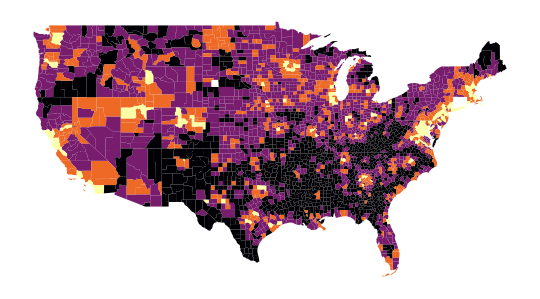

The scatter plot from question 5, representing
the relationship between `Median_Household_Income_2021`
and `Unemployment_rate_2019`, will have the following appearance:

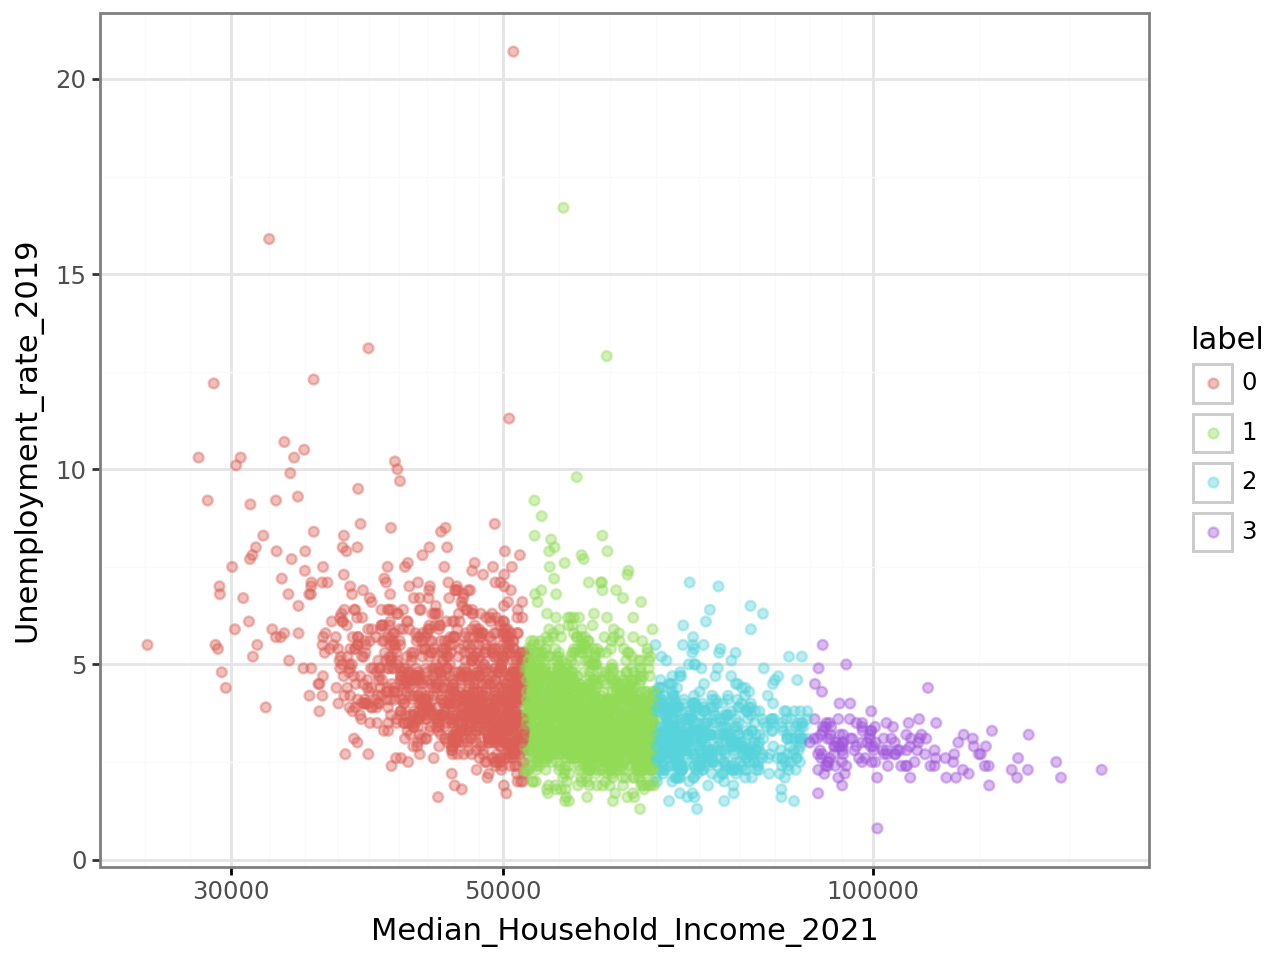

The classification appears too distinct in this figure.
This suggests that the income variable (`Median_Household_Income_2021`)
explains the partitioning produced by our model too well to be normal.
This is likely due to the high variance of income compared to other variables.
In such situations, as mentioned earlier, it is recommended to standardize the variables.

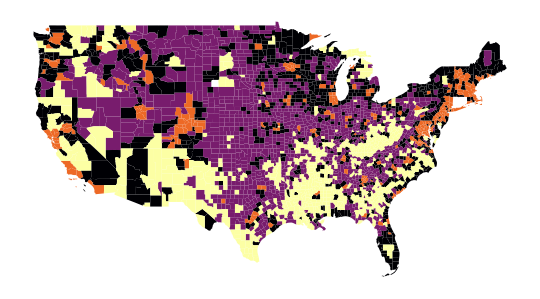

Thus, the following map is obtained in question 5:

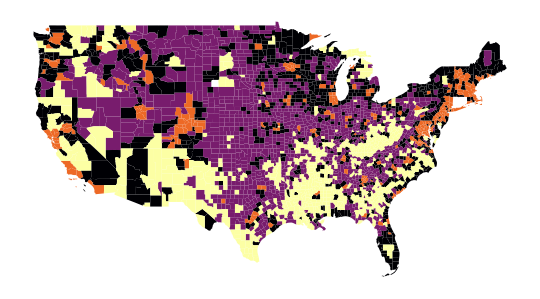

And the scatter plot from question 5 has a less deterministic appearance, which is preferable:

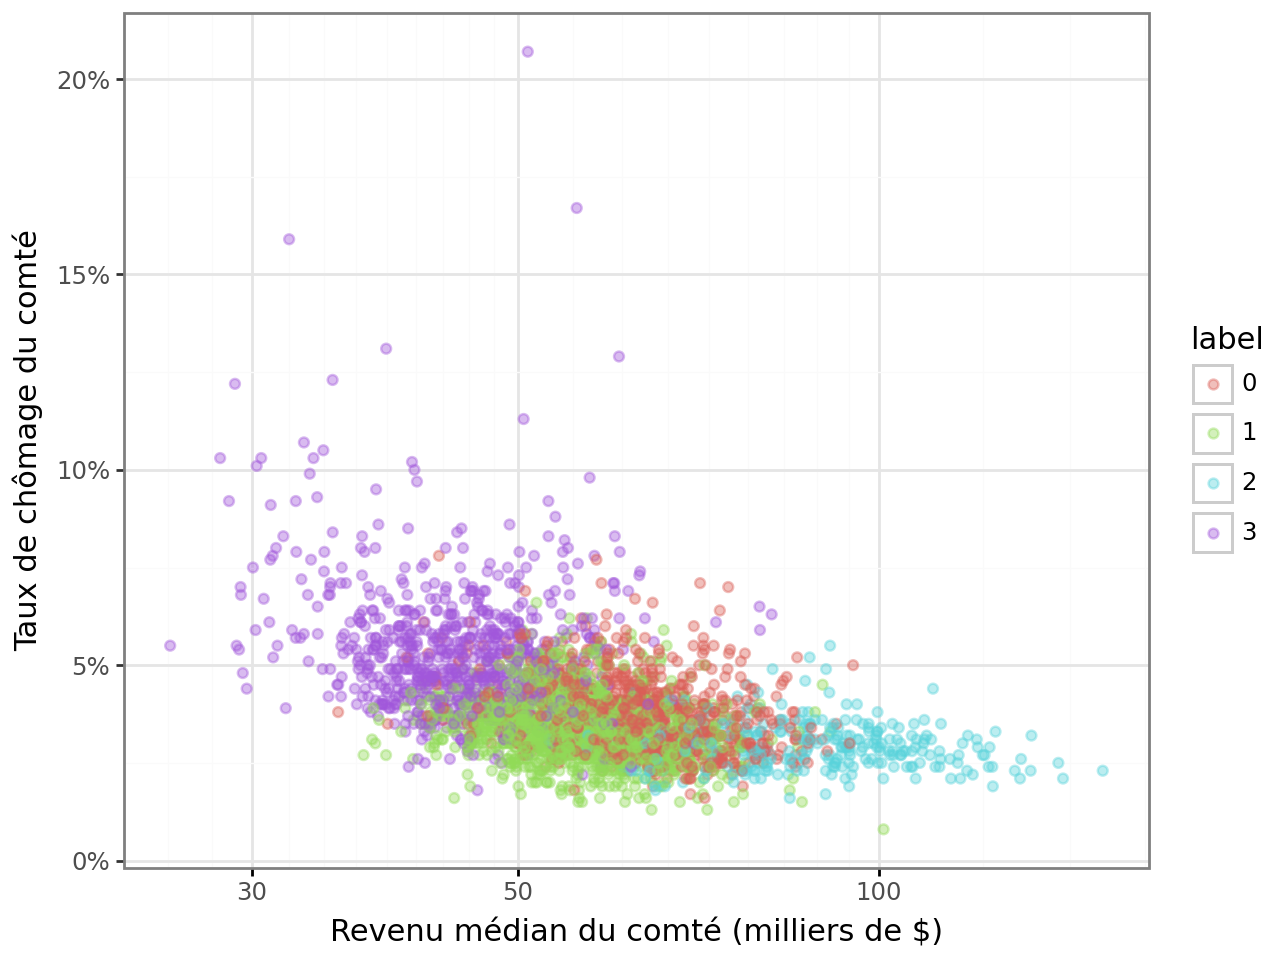

Finally, regarding question 6, the following histogram of votes for each cluster is obtained:

/opt/conda/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 31'. Pick better value with 'binwidth'.

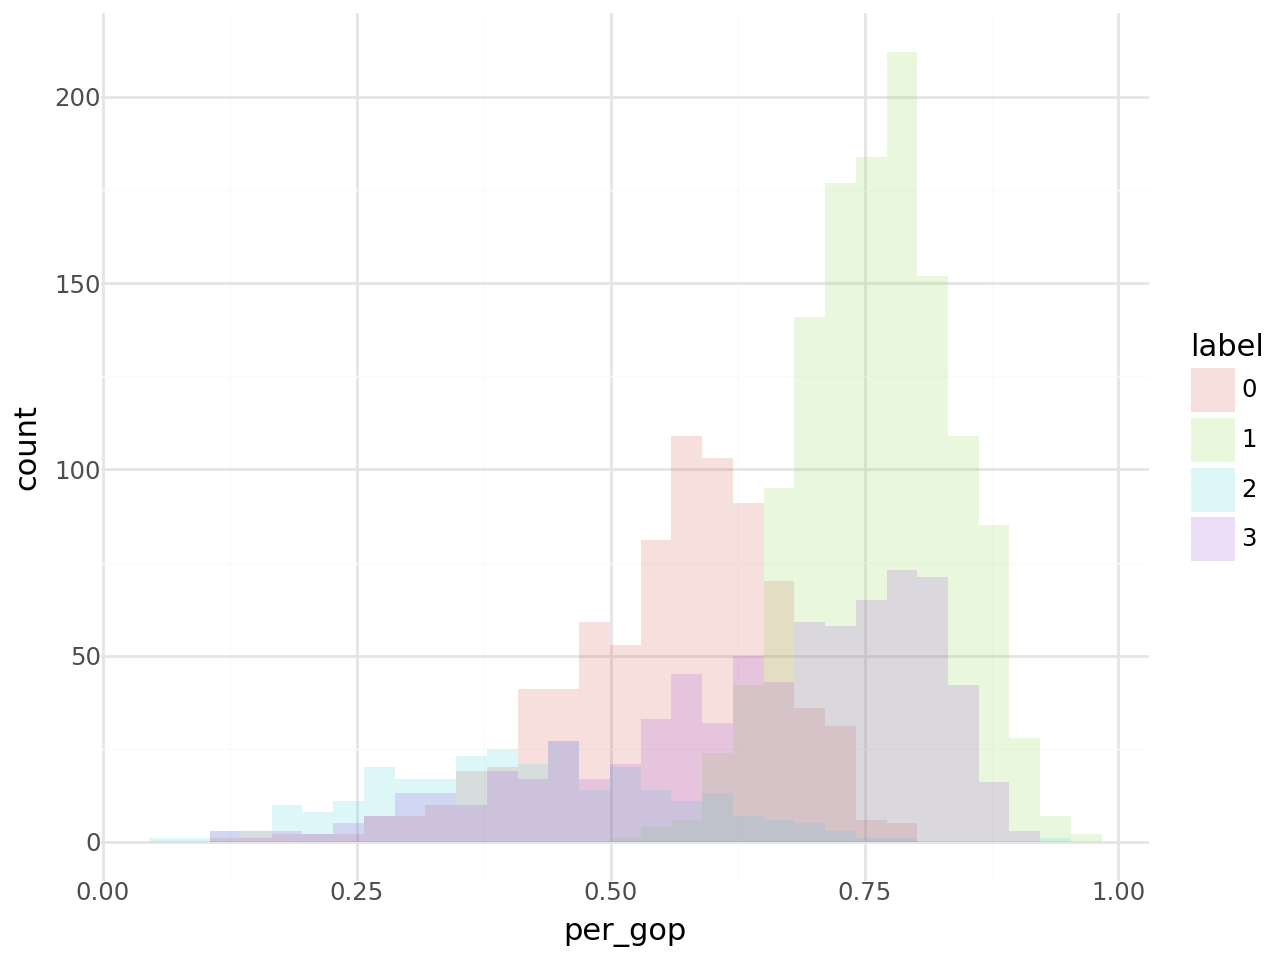

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-lightbulb"></i> Tip</h3>

Several points about the algorithm implemented by default in `scikit-learn` should be noted, as outlined in
the documentation:

-   The default algorithm is kmeans++ (see the `init` parameter). This means that
    the initialization of centroids is done intelligently so that the initial centroids are chosen
    to avoid being too close to each other.
-   The algorithm will start with `n_init` different centroids, and the model will select the best initialization
    based on the model’s *inertia*, with a default value of 10.

The model outputs the `cluster_centers_`, the labels `labels_`, the inertia `inertia_`, and the number of iterations
`n_iter_`.

</div>

## 2.2 Choosing the Number of Clusters

The number of clusters is determined by the modeler.
There are several ways to determine this number:

-   Prior knowledge of the problem;
-   Analysis of a specific metric to define the number of clusters to choose;
-   Etc.

There is a trade-off between bias and variance:
too many clusters result in very low intra-cluster variance (overfitting, although it is never possible to determine the true type of an observation since this is unsupervised learning).

Without prior knowledge of the number of clusters, two families of methods can be used:

-   **The elbow method**: Take the inflection point of the model’s performance curve. This represents the moment when adding another cluster (increasing model complexity) provides only moderate gains in data modeling.

-   **The silhouette score**: This measures the similarity between a point and other points in the cluster relative to other clusters. Specifically:

> Silhouette value is a measure of how similar an object is to its own cluster
> (cohesion) compared to other clusters (separation). The silhouette ranges
> from −1 to +1, where a high value indicates that the object is
> well matched to its own cluster and poorly matched to neighboring
> clusters. If most objects have a high value, then the clustering
> configuration is appropriate. If many points have a low or negative
> value, then the clustering configuration may have too many or too few clusters
>
> Source: [Wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering))

The silhouette score for an observation is therefore equal to
`(m_nearest_cluster - m_intra_cluster)/max( m_nearest_cluster,m_intra_cluster)`
where `m_intra_cluster` is the mean distance of the observation to observations in the same cluster,
and `m_nearest_cluster` is the mean distance of the observation to observations in the nearest cluster.

The `yellowbrick` package provides a useful extension to `scikit` for visually representing
the performance of our clustering algorithms.

Let us start again with a simple model.

In [19]:
xvars = [
  'Unemployment_rate_2019', 'Median_Household_Income_2021',
  'Percent of adults with less than a high school diploma, 2018-22',
  "Percent of adults with a bachelor's degree or higher, 2018-22"
]

df2 = votes[xvars + ["per_gop"]].dropna()
model = KMeans(n_clusters=4)

In [20]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(model, k=(2,12))
visualizer.fit(df2.loc[:,xvars])        # Fit the data to the visualizer
visualizer.show()

For the elbow method, the model’s performance curve shows a slight elbow at $k=4$. The initial model
therefore seemed appropriate.

`yellowbrick` also allows the representation of silhouettes, but the interpretation is less straightforward, and the computational cost is higher:

In [21]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
j=0
for i in [3, 4, 6, 10]:
    j += 1
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(j, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    ax[q-1][mod].set_title("k = " + str(i))
    visualizer.fit(df2[xvars])

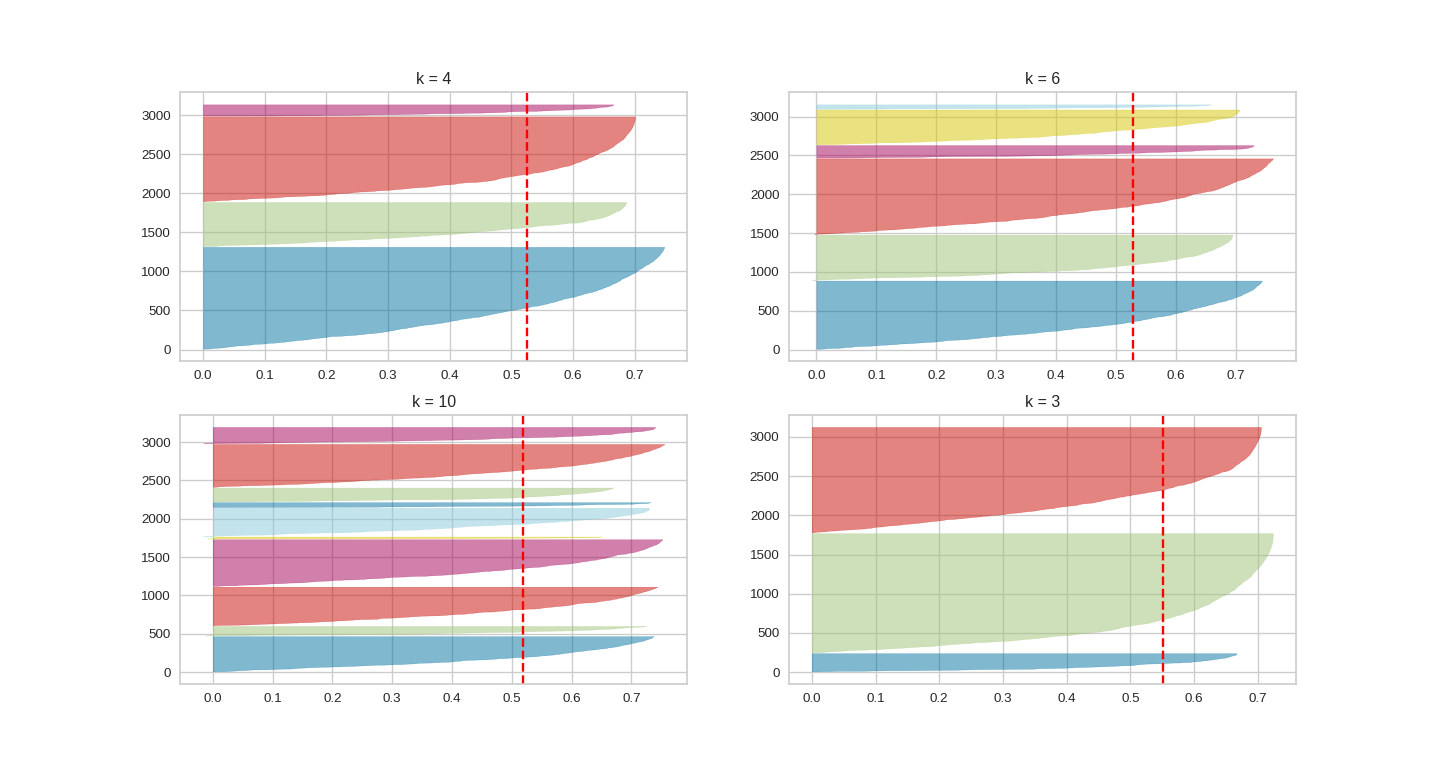

The silhouette score provides a richer representation than the elbow curve.

In this graph, the red dashed vertical lines represent the global silhouette score
for each chosen `k`. For example, we can see that for all the `k` values represented here, the
silhouette score is between 0.5 and 0.6 and varies little.
Then, for a given `k`, the silhouette scores for each
observation are displayed, grouped by cluster.
For instance, for `k = 4`, here, we clearly see four different colors representing the 4 modeled clusters.
The y-axis represents all clustered observations, and the x-axis shows the silhouette score of
each observation. If, within a cluster, observations have a silhouette score lower than the
global silhouette score (red vertical line), this indicates that the cluster’s observations are
too close to other clusters.

This representation also allows us to assess the relative size of clusters. For example,
with `k = 3`, we see two large clusters and one “smaller” cluster relative to the others.
This can help us decide whether to aim for clusters of homogeneous sizes or not.

Finally, when the silhouette score is negative, it indicates that the mean distance of an observation
to observations in the nearest cluster is smaller than the mean distance of the observation to
observations in its own cluster. This means the observation is misclassified.

## 2.3 Other Clustering Methods

There are many other clustering methods. Among the most well-known, here are three notable examples:

-   Hierarchical Agglomerative Clustering (HAC);
-   DBSCAN;
-   Gaussian Mixture Models.

### 2.3.1 Hierarchical Agglomerative Clustering (HAC)

What is the principle?

-   Start by calculating the dissimilarity between our *N* individuals, i.e., their pairwise distances in the variable space.
-   Then, group the two individuals whose grouping minimizes a given aggregation criterion, thus creating a class containing these two individuals.
-   Next, calculate the dissimilarity between this class and the *N-2* other individuals using the aggregation criterion.
-   Then, group the two individuals or classes of individuals whose grouping minimizes the aggregation criterion.
-   Continue until all individuals are grouped.

These successive groupings produce a binary classification tree (dendrogram), where the root corresponds to the class grouping all individuals. This dendrogram represents a hierarchy of partitions. A partition can be chosen by truncating the tree at a certain level, based on either user constraints or more objective criteria.

More information [here](https://www.xlstat.com/en/solutions/features/hierarchical-clustering-hac).

### 2.3.2 DBSCAN

The [DBSCAN algorithm](https://en.wikipedia.org/wiki/DBSCAN) is implemented in `sklearn.cluster`.
It can be used notably for anomaly detection.
This method is based on clustering in regions of continuous observation density using the concept of neighborhood within a certain epsilon distance.
For each observation, it is checked whether there are neighbors within its epsilon-distance neighborhood. If there are at
least `min_samples` neighbors, the observation will be a *core instance*.

Observations that are not *core instances* and have no *core instances* in their epsilon-distance neighborhood
will be detected as anomalies.

### 2.3.3 Gaussian Mixture Models

For theoretical insights, see the course [Probabilistic and Computational Statistics, M1 Jussieu, V.Lemaire and T.Rebafka](https://perso.lpsm.paris/~rebafka/#enseignement).
Refer especially to the notebooks for the EM algorithm for Gaussian mixture models.

In `sklearn`, Gaussian mixture models are implemented in `sklearn.mixture` as `GaussianMixture`.
Key parameters include the number of Gaussians `n_components` and the number of initializations `n_init`.
Gaussian mixture models can also be used for anomaly detection.

<div class="alert alert-info" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-comment"></i> Going Further</h3>

There are many other clustering methods:

-   Local Outlier Factor;
-   Bayesian Gaussian Mixture Models;
-   Other Hierarchical Clustering Methods;
-   Etc.

</div>

# 3. Principal Component Analysis (PCA)

## 3.1 For Cluster Visualization

The simplest method to visualize *clusters*, regardless of how they were obtained, would be to represent each individual in the *N*-dimensional space of the table’s variables, coloring each individual based on their cluster.
This would clearly differentiate the most discriminating variables and the various groups.
One issue here: as soon as *N \> 3*, it becomes difficult to represent the results intelligibly…

This is where **Principal Component Analysis** ([PCA](https://www.xlstat.com/en/solutions/features/principal-component-analysis-pca)) comes into play, allowing us to project our high-dimensional space into a smaller-dimensional space.
The major constraint of this projection is to retain the maximum amount of information (measured by the total variance of the dataset) within our reduced number of dimensions, called principal components.
By limiting to 2 or 3 dimensions, we can visually represent relationships between observations with minimal loss of reliability.

We can generally expect that clusters determined in our N-dimensional space will differentiate well in our PCA projection and that the composition of the principal components based on the initial variables will help interpret the obtained clusters.
Indeed, the linear combination of columns creating our new axes often has “meaning” in the real world:

-   Either because a small handful of variables represent the majority of the component;
-   Or because most columns contributing to the summed component combine well to form a natural interpretation.

To practice cluster creation methods, from raw data to PCA visualization, refer to part 2 of subject 3 in the 2023 funathon, *Explore the eating habits of our compatriots*, on [SSP Cloud](https://www.sspcloud.fr/formation?search=funath&path=%5B%22Funathon%202023%22%5D) or on [Github](https://github.com/InseeFrLab/funathon2023_sujet3/).

## 3.2 For Dimensionality Reduction

PCA is also very useful in reducing the number of variables for many types of modeling, such as linear regression.
It is possible to project the space of explanatory variables into a lower-dimensional space, specifically to limit the risks of *overfitting*.

The drawback of this approach is that it makes the data used as input for the model less interpretable compared to LASSO, as the latter selects variables, while PCA selects linear combinations of our variables.

## 3.3 Example

Let us revisit our previous data. Before performing a principal component analysis, whose objective is to synthesize sources of variability in our data, it is advisable to standardize the variables when they have different scales (which is the case here).

Dimensions des données avant PCA : (3099, 4)

Let us start with a preliminary test by reducing our data to two components, that is, two linear combinations of the data. This is a very practical method implemented in `Scikit`. Doing it manually would be cumbersome.

In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

n_components = 2
pca = PCA(n_components=n_components)

Géron, Aurélien. 2022. *Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow*. " O’Reilly Media, Inc.".